# Small Nimmt 6 tournament

In [1]:
import numpy as np
import logging
import sys
import torch
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("../")

from rl_6_nimmt import Tournament, GameSession
from rl_6_nimmt.agents import Human, DrunkHamster, MaskedReinforceAgent, BatchedReinforceAgent, BatchedACERAgent

logging.basicConfig(format="%(message)s",level=logging.INFO)
for name in logging.root.manager.loggerDict:
    if not "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.WARNING)


## Agents

In [2]:
agents = {}

for i in range(1):
    agents[f"Batched REINFORCE {i+1}"] = BatchedReinforceAgent(r_factor=0.1)
    agents[f"Batched REINFORCE {i+1}"].train()
    
for i in range(1):
    agents[f"Masked REINFORCE {i+1}"] = MaskedReinforceAgent(r_factor=0.1)
    agents[f"Masked REINFORCE {i+1}"].train()
    
for i in range(2):
    agents[f"Batched ACER {i+1}"] = BatchedACERAgent()
    agents[f"Batched ACER {i+1}"].train()
    
for i in range(1):
    agents[f"Random {i+1}"] = DrunkHamster()
    
baseline_agents = [DrunkHamster()]

merle = Human("Merle")


In [ ]:
tournament = Tournament(min_players=2, max_players=2, baseline_agents=baseline_agents)

for name, agent in agents.items():
    tournament.add_player(name, agent)

print(tournament)

## Load existing state (skip when running this for the first time)

In [4]:
agents, tournament = pickle.load(open("./.tournament.pickle", "rb"))

## Let the games begin

In [ ]:
num_games = 50000
block_len = 5000

tqdm._instances.clear()  # Important after cancelling any step

while tournament.total_games < num_games:
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)


In [58]:
pickle.dump((agents, tournament), open( "./.tournament.pickle", "wb" ))

## Let's see the results

In [5]:
print(tournament)

Tournament after 30660 games:
--------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament pos | Baseline score | Baseline pos 
--------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 18364 |            -9.85 |           0.46 |          -8.27 |         0.21 
   Masked REINFORCE 1 | 18374 |            -9.79 |           0.49 |          -7.65 |         0.67 
       Batched ACER 1 | 18314 |            -7.99 |           0.58 |          -7.57 |         0.42 
       Batched ACER 2 | 18369 |            -8.35 |           0.56 |          -7.59 |         0.47 
             Random 1 | 18429 |           -11.39 |           0.42 |          -8.01 |         0.67 
--------------------------------------------------------------------------------------------------


In [6]:
def create_color(name):
    if "Batched REINFORCE" in name:
        return "C0"
    elif "Masked REINFORCE" in name:
        return "C1"
    elif "Batched ACER" in name:
        return "C2"
    elif "Random" in name:
        return "0.6"
    
    
def create_label(name):
    return name[:-2] if "1" in name else None


def plot_running_mean(x, y, n=10, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
    cumsum = np.cumsum(np.insert(x, 0, 0))
    running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
    plt.plot(running_mean_x, running_mean_y, **kwargs)


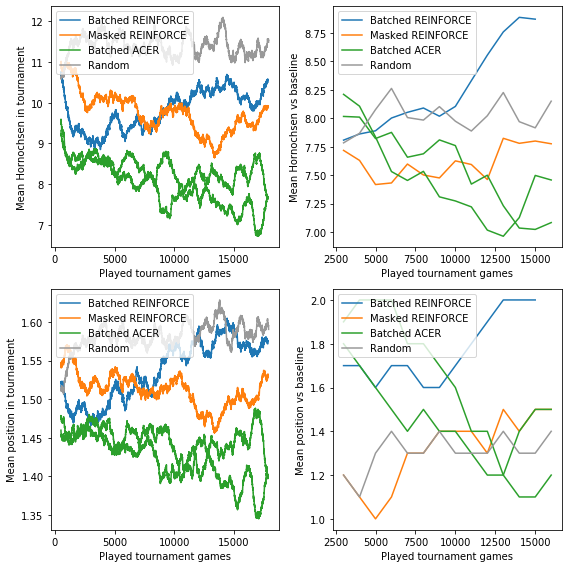

In [7]:
fig = plt.figure(figsize=(8,8))

labels = [
    "Mean Hornochsen in tournament",
    "Mean Hornochsen vs baseline",
    "Mean position in tournament",
    "Mean position vs baseline"
]
quantities = [
    tournament.tournament_scores,
    tournament.baseline_scores,
    tournament.tournament_positions,
    tournament.baseline_positions
]
fns = [lambda x : -x, lambda x : -x, lambda x : 2. - x, lambda x : 2. - x]
baselines = [False, True, False, True]

for panel, (quantity, label, fn, baseline) in enumerate(zip(quantities, labels, fns, baselines)):
    ax = plt.subplot(2,2,panel + 1)
    
    for name in tournament.agents.keys():
        y = np.array(quantity[name])
        x = 1000 * np.arange(1, len(y) + 1) if baseline else np.arange(1, len(y) + 1)
        plot_running_mean(x, fn(y), n = 5 if baseline else 1000, label=create_label(name), color=create_color(name))
    
    plt.legend(loc="upper left")
    plt.xlabel("Played tournament games")
    plt.ylabel(label)

plt.tight_layout()
plt.show()


## Winner vs Merle

In [9]:
session = GameSession(merle, tournament.winner())

# The DEBUG output shows the moves, which is nice
for name in logging.root.manager.loggerDict:
    if "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.DEBUG)
        

In [10]:
session.play_game(render=True)

Dealing cards
--------------------------------------------------------------------------------
Board:
   10:   _    _    _    _    * 
   30:   _    _    _    _    * 
   55#   _    _    _    _    * 
   27    _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   12   22+  34   39   50:  67   85.  93   96 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  16   17   41   53   61   66+  83   86   87   97 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  12  22  34  39  50  67  85  93  96. Choose one to play! 93


Merle          (player 1) plays card 93
Batched ACER 1 (player 2) plays card 97
--------------------------------------------------------------------------------
Board:
   10:   _    _    _    _    * 
   30:   _    _    _    _    * 
   55#  93   97    _    _    * 
   27    _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   12   22+  34   39   50:  67   85.  96 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  16   17   41   53   61   66+  83   86   87 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  12  22  34  39  50  67  85  96. Choose one to play! 34


Merle          (player 1) plays card 34
Batched ACER 1 (player 2) plays card 86
--------------------------------------------------------------------------------
Board:
   10:   _    _    _    _    * 
   30:  34   86    _    _    * 
   55#  93   97    _    _    * 
   27    _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   12   22+  39   50:  67   85.  96 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  16   17   41   53   61   66+  83   87 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  12  22  39  50  67  85  96. Choose one to play! 12


Merle          (player 1) plays card 12
Batched ACER 1 (player 2) plays card 87
--------------------------------------------------------------------------------
Board:
   10:  12    _    _    _    * 
   30:  34   86   87    _    * 
   55#  93   97    _    _    * 
   27    _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   22+  39   50:  67   85.  96 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  16   17   41   53   61   66+  83 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  22  39  50  67  85  96. Choose one to play! 96


Batched ACER 1 (player 2) plays card 83
Merle          (player 1) plays card 96
--------------------------------------------------------------------------------
Board:
   10:  12    _    _    _    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
   27   83    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   22+  39   50:  67   85.
  Batched ACER 1 (player 2):   0 Hornochsen, cards  16   17   41   53   61   66+
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  22  39  50  67  85. Choose one to play! 22


Merle          (player 1) plays card 22
Batched ACER 1 (player 2) plays card 66
--------------------------------------------------------------------------------
Board:
   10:  12   22+  66+   _    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
   27   83    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   39   50:  67   85.
  Batched ACER 1 (player 2):   0 Hornochsen, cards  16   17   41   53   61 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  39  50  67  85. Choose one to play! 67


Batched ACER 1 (player 2) plays card 17
  ...chooses to replace row 4
  ...and gains 2 Hornochsen
Merle          (player 1) plays card 67
--------------------------------------------------------------------------------
Board:
   10:  12   22+  66+  67    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
   17    _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   39   50:  85.
  Batched ACER 1 (player 2):   2 Hornochsen, cards  16   41   53   61 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  39  50  85. Choose one to play! 39


Merle          (player 1) plays card 39
Batched ACER 1 (player 2) plays card 61
--------------------------------------------------------------------------------
Board:
   10:  12   22+  66+  67    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
   17   39   61    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   7   50:  85.
  Batched ACER 1 (player 2):   2 Hornochsen, cards  16   41   53 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  50  85. Choose one to play! 50


Merle          (player 1) plays card 50
  ...chooses to replace row 4
  ...and gains 3 Hornochsen
Batched ACER 1 (player 2) plays card 53
--------------------------------------------------------------------------------
Board:
   10:  12   22+  66+  67    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
   50:  53    _    _    _    * 
Players:
  Merle          (player 1):   3 Hornochsen, cards   7   85.
  Batched ACER 1 (player 2):   2 Hornochsen, cards  16   41 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  85. Choose one to play! 7


Merle          (player 1) plays card 7
  ...chooses to replace row 4
  ...and gains 4 Hornochsen
Batched ACER 1 (player 2) plays card 16
--------------------------------------------------------------------------------
Board:
   10:  12   22+  66+  67    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
    7   16    _    _    _    * 
Players:
  Merle          (player 1):   7 Hornochsen, cards  85.
  Batched ACER 1 (player 2):   2 Hornochsen, cards  41 
--------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  85. Choose one to play! 85


Batched ACER 1 (player 2) plays card 41
Merle          (player 1) plays card 85
  ...and gains 15 Hornochsen
--------------------------------------------------------------------------------
Board:
   85.   _    _    _    _    * 
   30:  34   86   87   96    * 
   55#  93   97    _    _    * 
    7   16   41    _    _    * 
Players:
  Merle          (player 1):  22 Hornochsen, no cards 
  Batched ACER 1 (player 2):   2 Hornochsen, no cards 
The game is over! Batched ACER 1 (player 2) wins, Merle          (player 1) loses. Congratulations!
--------------------------------------------------------------------------------
